In [28]:
import os
from zipfile import ZipFile
from pathlib import Path
import requests

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (12, 9)
plt.rcParams["font.family"] = "DejaVu Sans"

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [29]:
def load_har_dataset(url, extract_path: Path, filename: str, overwrite=False):
    # check if existed already
    filepath = extract_path / filename
    if filepath.exists() and not overwrite:
        print("The dataset is already in place.")
        return

    print("Downloading the dataset from:  ", url)
    response = requests.get(url)

    with open(filepath, 'wb') as f:
        f.write(response.content)

    with ZipFile(filepath, 'r') as zipObj:
        # Extract all the contents of zip file in current directory
        zipObj.extractall(extract_path)

In [30]:
data_path = '../mlcourse.ai_Dataset/'

In [31]:
X_train = np.loadtxt(data_path + 'samsung_train.txt')
y_train = np.loadtxt(data_path + 'samsung_train_labels.txt').astype(int)

X_test = np.loadtxt(data_path + 'samsung_test.txt')
y_test = np.loadtxt(data_path + 'samsung_test_labels.txt').astype(int)

In [32]:
# Checking dimensions
assert X_train.shape == (7352, 561) and y_train.shape == (7352,)
assert X_test.shape == (2947, 561) and y_test.shape == (2947,)

In [33]:
X_train.shape

(7352, 561)

In [34]:
X_test.shape

(2947, 561)

In [35]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [36]:
X.shape

(10299, 561)

In [37]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [38]:
n_classes = np.unique(y).size

In [39]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [40]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

In [41]:
X_pca.shape

(10299, 65)

Question 1: What is the minimum number of principal components required to cover the 90% of the variance of the original (scaled) data?

65

In [42]:
print(f'The amount of variance covered by first PC: {pca.explained_variance_ratio_[0]*100}%')

The amount of variance covered by first PC: 50.73822103501334%


Question 2:
What percentage of the variance is covered by the first principal component? Round to the nearest percent.

~51%

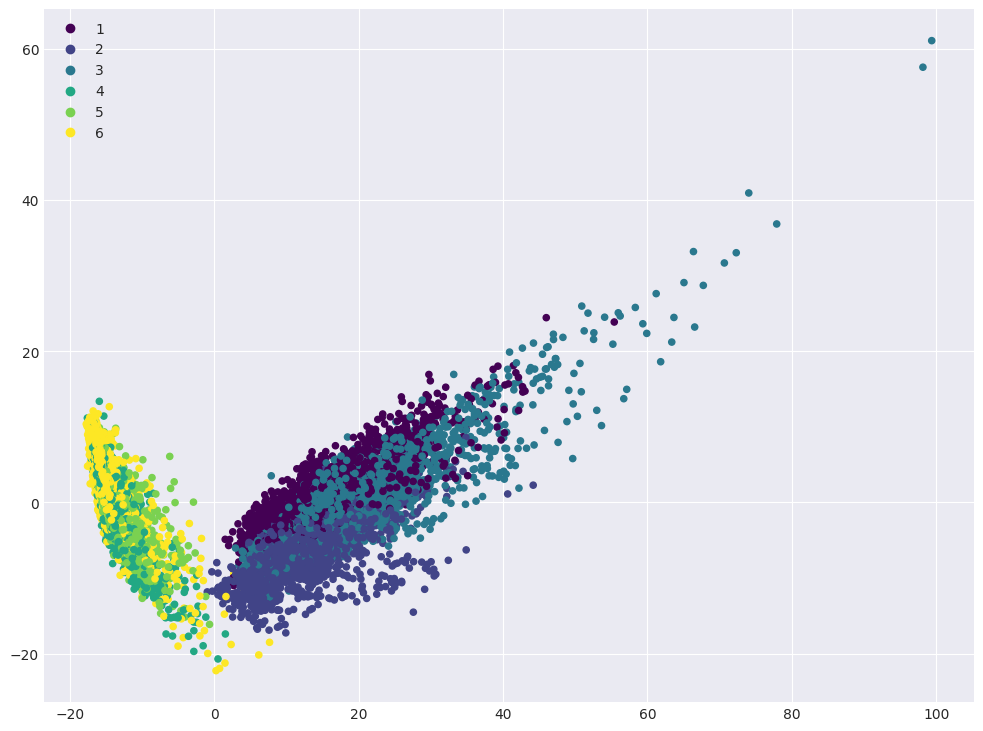

In [43]:
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=20, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=np.char.mod('%s', np.unique(y)).tolist())

In [44]:
k_means = KMeans(n_clusters=np.unique(y).size, n_init=100, random_state=RANDOM_STATE)

y_pred = k_means.fit(X_pca).labels_

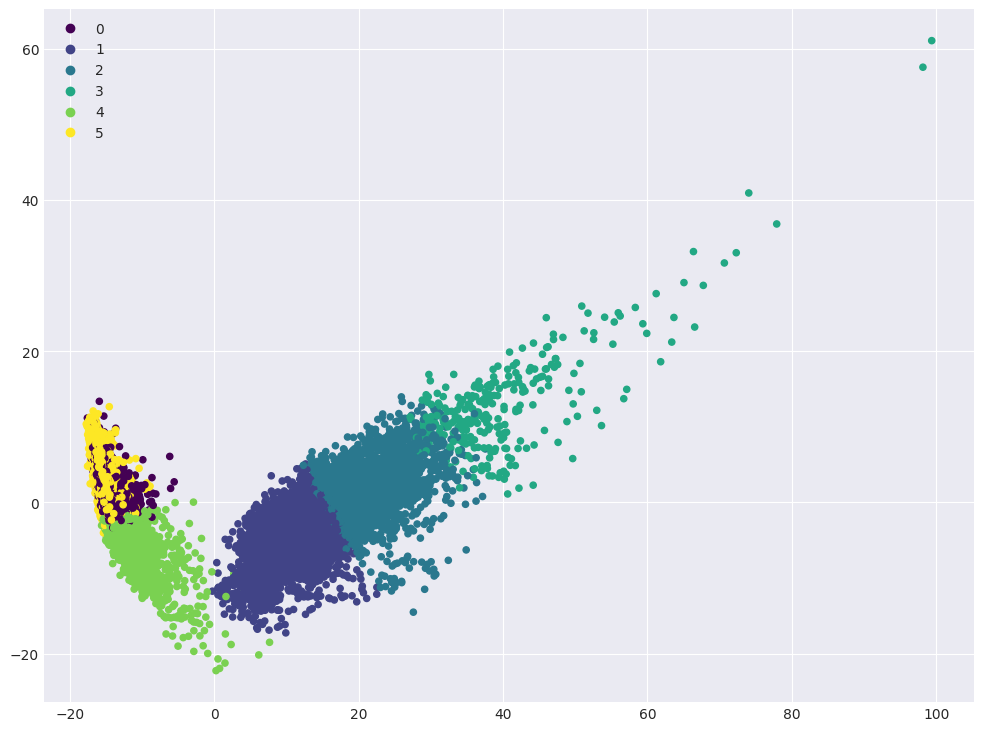

In [45]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_pred, s=20, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=np.char.mod('%s', np.unique(y_pred)).tolist())

In [46]:
tab = pd.crosstab(y, y_pred, margins=True)
tab.index = ['walking', 'going up the stairs',
            'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,0,903,741,78,0,0,1722
going up the stairs,0,1241,296,5,2,0,1544
going down the stairs,0,320,890,196,0,0,1406
sitting,1235,1,0,0,450,91,1777
standing,1344,0,0,0,562,0,1906
laying,52,5,0,0,329,1558,1944
all,2631,2470,1927,279,1343,1649,10299


Question 3: If everything worked out correctly, you will see a number of clusters, almost perfectly separated from each other. What types of activity are included in these clusters?

2 clusters: (walking, walking upstairs, walking downstairs ) and (sitting, standing, laying)

In [47]:
for index, data in tab.iterrows():
    print(f'{index}\t\t\t -> {np.max(data[:-1])/data[-1]}')

walking			 -> 0.524390243902439
going up the stairs			 -> 0.8037564766839378
going down the stairs			 -> 0.6330014224751067
sitting			 -> 0.694991558806978
standing			 -> 0.7051416579223505
laying			 -> 0.801440329218107
all			 -> 0.2554616953102243


/tmp/ipykernel_11455/2132634.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{index}\t\t\t -> {np.max(data[:-1])/data[-1]}')


Question 4: Which activity is separated from the rest better than others based on the simple metric described above?

all three options are incorrect

In [48]:
inertia = []
for k in tqdm(range(1, n_classes + 1)):
    k_means = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(k_means.inertia_)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [01:26<00:00, 14.50s/it]


Text(0, 0.5, '$J(C_k)$')

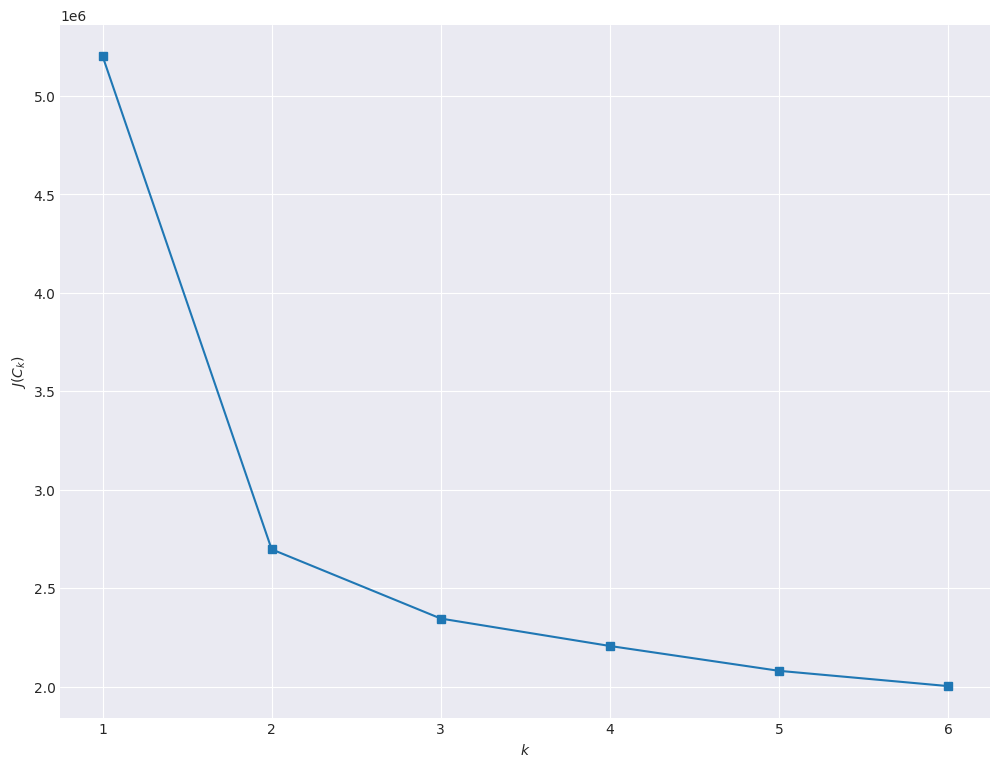

In [49]:
plt.plot(range(1, n_classes + 1), inertia, marker="s")
plt.xlabel("$k$")
plt.ylabel("$J(C_k)$")

How many clusters can we choose according to the elbow method?

2


In [50]:
ag_pred = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit_predict(X_pca)
metrics.adjusted_rand_score(y, ag_pred)

0.49362763373004886

In [51]:
k_means_pred = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE).fit_predict(X_pca)

metrics.adjusted_rand_score(y,k_means_pred)

0.4198070012602345

Question 6:
Select all the correct statements.

According to ARI, KMeans handled clustering worse than Agglomerative Clustering

For ARI, it does not matter which tags are assigned to the cluster, only the partitioning of instances into clusters matters

In case of random partitioning into clusters, ARI will be close to zero



In [52]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [53]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {"C": [0.001, 0.01, 0.1, 1, 10]}

In [54]:
best_svc = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1)
best_svc.fit(X_train_scaled, y_train)

best_svc.best_params_, best_svc.best_score_

/home/vitalijs_tickovs/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vitalijs_tickovs/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vitalijs_tickovs/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


({'C': 0.1}, np.float64(0.9379785010699506))

Question 7
Which value of the hyperparameter C was chosen the best on the basis of cross-validation?

0.1

In [61]:
y_predicted = best_svc.predict(X_test_scaled)

tab = pd.crosstab(y_test, y_predicted)
tab.index = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying']
tab.columns = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying']
tab

,walking,climbing up the stairs,going down the stairs,sitting,standing,laying
walking,479,11,4,2,0,0
climbing up the stairs,4,465,1,1,0,0
going down the stairs,1,2,416,1,0,0
sitting,0,4,0,433,52,2
standing,0,0,0,16,516,0
laying,0,0,0,0,7,530


In [68]:
tp = pd.Series(np.diag(tab)).values
precision = tp / tab.sum(axis=0)  # sum over columns
recall = tp / tab.sum(axis=1)  # sum over rows

print(precision.sort_values())
print(recall.sort_values())

standing                  0.897391
sitting                   0.955850
climbing up the stairs    0.964730
going down the stairs     0.988124
walking                   0.989669
laying                    0.996241
dtype: float64
sitting                   0.881874
walking                   0.965726
standing                  0.969925
laying                    0.986965
climbing up the stairs    0.987261
going down the stairs     0.990476
dtype: float64


Question 8:
Which activity type is worst detected by SVM in terms of precision? Recall?

precision – standing, recall – sitting



In [56]:
X_train_scaled_pca = pca.fit_transform(X_train_scaled)

X_test_scaled_pca = pca.transform(X_test_scaled)

In [57]:
best_svc_pca = GridSearchCV(svc, svc_params, n_jobs=-1, cv=3)
best_svc_pca.fit(X_train_scaled_pca, y_train)

,estimator,LinearSVC(random_state=17)
,param_grid,"{'C': [0.001, 0.01, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [58]:
best_svc_pca.best_params_, best_svc_pca.best_score_

({'C': 0.1}, np.float64(0.8983982658750974))

In [59]:
round(100 * (best_svc_pca.best_score_ - best_svc.best_score_))

-4

Question 9:
What is the difference between the best quality (accuracy) for cross-validation in the case of all 561 initial characteristics and in the second case, when the principal component method was applied? Round to the nearest percent.

4%

Question 10:
Select all the correct statements:

PCA can be used to visualize data, but there are better methods for this task, for example, tSNE. However, PCA has lower computational complexity

PCA builds linear combinations of initial features, and in some applications they might be poorly interpreted by humans

